In [ ]:
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import spatial
from scipy.sparse import hstack, lil_matrix, csr_matrix

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score
from sklearn.metrics.pairwise import paired_distances
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

import csv
import urllib.request
import io
import zipfile
import os

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
!pip install gensim

## Preprocessing

Читаем данные и приводим их к нужному формату.

In [ ]:
train = pd.read_json('multinli_1.0_train.jsonl', lines = True)
val_mismatched = pd.read_json('multinli_1.0_dev_mismatched.jsonl', lines = True)
val_matched = pd.read_json('multinli_1.0_dev_matched.jsonl', lines = True)
test_mismatched = pd.read_json('multinli_0.9_test_mismatched_unlabeled.jsonl', lines = True)
test_matched = pd.read_json('multinli_0.9_test_matched_unlabeled.jsonl', lines = True)


In [ ]:
full = {'train': train, 'val_matched':val_matched, 'test_matched': test_matched, 'val_mismatched':val_mismatched, 'test_mismatched': test_mismatched}

Удаляем объекты, для которых не определен класс.

In [ ]:
def delete_unsure_labels(data): 
    data = data.drop(index = data[data.gold_label == '-'].index)
    return data


for frame in full:
    full[frame] = delete_unsure_labels(full[frame])

In [ ]:
train = full['train']
val_matched = full['val_matched']
val_mismatched = full['val_mismatched']
test_matched = full['test_matched']
test_mismatched = full['test_mismatched']

In [ ]:
val = pd.concat([val_matched, val_mismatched ], axis = 0)

## Метрика

Создаем свою метрику с весами 0.8, 0.1 и 0.1.

In [ ]:
def print_metric(y_true, y_preds):
    prfs = precision_recall_fscore_support(y_true, y_preds, beta=3, average=None, labels=['contradiction', 'neutral', 'entailment'])
    matrix_report = pd.DataFrame(prfs, columns = ['contradiction', 'neutral', 'entailment'], index = ['precision', 'recall', 'fscore', 'support'])
    matrix_report['Weighted*'] = 0.8 * matrix_report['contradiction'] +  0.1 * matrix_report['neutral'] +  0.1 * matrix_report['entailment']
    matrix_report.drop(index = 'support', inplace = True)
    print(f"{matrix_report.loc['fscore', 'Weighted*']:.4f}   Custom f-score")
    print(f"{matrix_report.loc['recall', 'contradiction']:.4f}   Contradiction's recall")
    print(f"{accuracy_score(y_true, y_preds):.4f}   Accuracy")
    print(matrix_report.T)

In [ ]:
f_scorer = make_scorer(fbeta_score, beta=3, average='weighted', labels=['contradiction', 'neutral', 'entailment'])

## Training

Функция обучения модели

In [ ]:
def log_reg_cv_and_validation(X_train, X_val, y_train, max_itr = 100):
    clf = LogisticRegression(solver = 'saga', max_iter = max_itr)

    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring= f_scorer)
    print(f'Cross val scores: {scores}')
    print(f'Mean cross val score: {scores.mean():.4f}')
    print('-'*40)

    clf.fit(X_train, y_train)
    y_train_preds = clf.predict(X_train)
    y_val_preds = clf.predict(X_val)

    print('Train score')
    print_metric(y_train, y_train_preds)
    print('-'*40)

    print('Val score')
    print_metric(y_val, y_val_preds)

## Word2vec

Получаем вектора на основе word2vec и обучаем модель.

Скачиваем модель

In [ ]:
zipFileURL = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
resp = urllib.request.urlopen(zipFileURL)
z_file = zipfile.ZipFile(io.BytesIO(resp.read()))

In [ ]:
os.mkdir('\w2v\wiki-news-300d-1M.vec')
z_file.extractall(path = 'w2v')

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('w2v/wiki-news-300d-1M.vec', binary=False)

Добавляем в данные столбцы с лемматизированными предложениями и со средними векторами каждого предложения

In [ ]:
def avg_vec(words, model, num_features): # считает средний вектор
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in model:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [ ]:
def add_avg_vec(data, sent, model): # добавляет вектора в датафрейм
    data[f'{sent}_lemmas'] = data[sent].apply(lambda x: tokenizer.tokenize(x.lower()))
    data[f'{sent}_avgvec'] = data[f'{sent}_lemmas'].apply(lambda x: avg_vec(x, model, 300))

In [ ]:
for data in [train, val, test_matched, test_mismatched]:
    for sent in ['sentence1', 'sentence2']:
        add_avg_vec(data, sent, model)

In [ ]:
def count_distances(data): 
    # преобразует предложения и считает расстояния(евклидово, матхэт., косинусное) между преобразованными предложениями
    vec_1 = np.array(data['sentence1_avgvec'].tolist())
    vec_2 = np.array(data['sentence2_avgvec'].tolist())
    euclidean = paired_distances(vec_1, vec_2, metric='euclidean')
    manhattan= paired_distances(vec_1, vec_2, metric='manhattan')
    cosine = paired_distances(vec_1, vec_2, metric='cosine')

    distances =  np.array([euclidean, manhattan, cosine]).T
    return distances

Считаем расстояния и обучаем модель

In [ ]:
X_train = count_distances(train)
y_train = np.array(train['gold_label'])
X_val = count_distances(val)
y_val = np.array(val['gold_label'])
X_test1 = count_distances(test_matched)
X_test2 = count_distances(test_mismatched)

In [ ]:
log_reg_cv_and_validation(X_train, X_val, y_train = y_train, max_itr = 500)

Cross val scores: [0.41394836 0.41378962 0.41523973]
Mean cross val score: 0.4143
----------------------------------------
Train score
0.2989   Custom f-score
0.2403   Contradiction's recall
0.4210   Accuracy
               precision    recall    fscore
contradiction   0.381902  0.240254  0.249509
neutral         0.442148  0.345149  0.352891
entailment      0.426161  0.677721  0.639945
Weighted*       0.392352  0.294490  0.298890
----------------------------------------
Val score
0.2991   Custom f-score
0.2371   Contradiction's recall
0.4371   Accuracy
               precision    recall    fscore
contradiction   0.387538  0.237099  0.246675
neutral         0.459321  0.328695  0.338316
entailment      0.445702  0.720686  0.678805
Weighted*       0.400533  0.294617  0.299052


## TF-IDF

Считаем расстояния на основе метрики TF-IDF и обучаем модель

In [ ]:
corpus = train.sentence1 +" "+ train.sentence2

In [ ]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Обучаем TF-IDF

In [ ]:
tfidf = TfidfVectorizer(stop_words=stop)
tfidf.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [ ]:
def tfidf_distance(data):
    # преобразует предложения и считает расстояния(евклидово, матхэт., косинусное) между преобразованными предложениями
    data_sentence1 = tfidf.transform(data.sentence1)
    data_sentence2 = tfidf.transform(data.sentence2)
    difference = data_sentence1 - data_sentence2
    
    euclidean = paired_distances(data_sentence1, data_sentence2, metric='euclidean')
    manhattan= paired_distances(data_sentence1, data_sentence2, metric='manhattan')
    cosine = paired_distances(data_sentence1, data_sentence2, metric='cosine')

    distances =  hstack((np.array([euclidean, manhattan, cosine]).T, difference))
    return distances

Считаем расстояния, обучаем модель только TF-IDF

In [ ]:
tfidf_train =  tfidf_distance(train)
tfidf_val = tfidf_distance(val)
tfidf_test1 = tfidf_distance(test_matched)
tfidf_test2 = tfidf_distance(test_mismatched)

In [ ]:
log_reg_cv_and_validation(tfidf_train, tfidf_val, y_train = y_train, max_itr = 500)

Cross val scores: [0.4792412  0.47753643 0.47988878]
Mean cross val score: 0.4789
----------------------------------------
Train score
0.5419   Custom f-score
0.5195   Contradiction's recall
0.5790   Accuracy
               precision    recall    fscore
contradiction   0.594572  0.519469  0.526114
neutral         0.578971  0.584248  0.583716
entailment      0.566900  0.633343  0.626006
Weighted*       0.590245  0.537334  0.541864
----------------------------------------
Val score
0.4733   Custom f-score
0.4527   Contradiction's recall
0.5116   Accuracy
               precision    recall    fscore
contradiction   0.508088  0.452658  0.457650
neutral         0.492914  0.506238  0.504873
entailment      0.530427  0.571305  0.566936
Weighted*       0.508805  0.469880  0.473301


TF-IDF + word2vec

In [ ]:
X_train = hstack((X_train, tfidf_train))
X_val = hstack((X_val, tfidf_val))
X_test1 = hstack((X_test1, tfidf_test1))
X_test2 = hstack((X_test2, tfidf_test2))

In [ ]:
log_reg_cv_and_validation(X_train, X_val, y_train = y_train, max_itr = 500)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Cross val scores: [0.49718565 0.49643292 0.49874039]
Mean cross val score: 0.4975
----------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train score
0.5291   Custom f-score
0.5049   Contradiction's recall
0.5703   Accuracy
               precision    recall    fscore
contradiction   0.582279  0.504885  0.511686
neutral         0.569149  0.569366  0.569344
entailment      0.562092  0.636590  0.628263
Weighted*       0.578947  0.524504  0.529110
----------------------------------------
Val score
0.4761   Custom f-score
0.4520   Contradiction's recall
0.5219   Accuracy
               precision    recall    fscore
contradiction   0.516375  0.452038  0.457741
neutral         0.500880  0.500480  0.500520
entailment      0.542769  0.606021  0.599040
Weighted*       0.517465  0.472280  0.476149


## Синтаксис

Считаем расстояния на основе представлений graph2vec и обучаем модель

In [ ]:
def read_csv_link(response): # читает вектора graph2vec из csv-файла
    spamreader = csv.reader(response)
    vectors = []
    i = 0
    for row in spamreader:
        if i == 0:
            i += 1
            continue
        row = [float(el) for el in row[1:]]
        vectors.append(row)
    return vectors

In [ ]:
def count_distances_link(file1, file2): # считает расстояния между векторами
    vectors_1 = read_csv_link(file1)
    vectors_2 = read_csv_link(file2)
    vectors_1 = np.array([np.array(vectors_1[i]) for i in range(len(vectors_1))])
    vectors_2 = np.array([np.array(vectors_2[i]) for i in range(len(vectors_2))])
    dist_1 = vectors_1 - vectors_2
    
    euclidean = paired_distances(vectors_1, vectors_2, metric='euclidean')
    manhattan= paired_distances(vectors_1, vectors_2, metric='manhattan')
    cosine = paired_distances(vectors_1, vectors_2, metric='cosine')

    distances =  np.array([euclidean, manhattan, cosine]).T
    return distances

Скачиваем файлы с гитхаба (файлы подготовлены через модуль graph2vec отдельно, так как включение кода в данный файл нерационально)

In [ ]:
response_val_1_1 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/val_1_1.csv')
response_val_2_1 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/val_2_1.csv')
response_val_1_2 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/val_1_2.csv')
response_val_2_2 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/val_2_2.csv')
response_test_1_1 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/test_1_1.csv')
response_test_2_1 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/test_2_1.csv')
response_test_1_2 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/test_1_2.csv')
response_test_2_2 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/test_2_2.csv')

X_val_1 = count_distances_link(io.TextIOWrapper(response_val_1_1), io.TextIOWrapper(response_val_2_1))
X_val_2 = count_distances_link(io.TextIOWrapper(response_val_1_2), io.TextIOWrapper(response_val_2_2))
semantic_val = np.vstack((X_val_1, X_val_2))

X_test_1 = count_distances_link(io.TextIOWrapper(response_test_1_1), io.TextIOWrapper(response_test_2_1))
X_test_2 = count_distances_link(io.TextIOWrapper(response_test_1_2), io.TextIOWrapper(response_test_2_2))
semantic_test = np.vstack((X_test_1, X_test_2))

In [ ]:
response_1 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/data_syntax/train_1_0.csv')
response_2 = urllib.request.urlopen('https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/data_syntax/train_2_0.csv')
semantic_train = count_distances_link(io.TextIOWrapper(response_1), io.TextIOWrapper(response_2))
for i in range(1, 69):
    response_1 = urllib.request.urlopen(f'https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/data_syntax/train_1_{i}.csv')
    response_2 = urllib.request.urlopen(f'https://raw.githubusercontent.com/ulianakazak/Bigutochki/main/data_syntax/train_2_{i}.csv')
    X = count_distances_link(io.TextIOWrapper(response_1), io.TextIOWrapper(response_2))
    semantic_train = np.vstack((semantic_train, X))

In [ ]:
def delete_unsure_labels_vec(X, data):
    X = X[data.index]
    return X

Обучаем модель, только для синтаксиса

In [ ]:
semantic_train = delete_unsure_labels_vec(semantic_train, train)
semantic_val = delete_unsure_labels_vec(semantic_val, val)

In [ ]:
log_reg_cv_and_validation(semantic_train, semantic_val, y_train = y_train, max_itr = 500)

Cross val scores: [0.32545514 0.32853169 0.33127668]
Mean cross val score: 0.3284
----------------------------------------
Train score
0.2664   Custom f-score
0.2301   Contradiction's recall
0.3351   Accuracy
               precision    recall    fscore
contradiction   0.335677  0.230102  0.237574
neutral         0.335460  0.413736  0.404302
entailment      0.334454  0.361607  0.358695
Weighted*       0.335533  0.261616  0.266359
----------------------------------------
Val score
0.1783   Custom f-score
0.1204   Contradiction's recall
0.3205   Accuracy
               precision    recall    fscore
contradiction   0.336364  0.120409  0.128670
neutral         0.318288  0.873001  0.743435
entailment      0.322751  0.008787  0.009734
Weighted*       0.333195  0.184506  0.178253


Синтаксис + TF-IDF + word2vec

In [ ]:
X_train_all = hstack((X_train, semantic_train))
X_val_all = hstack((X_val, semantic_val))

In [ ]:
log_reg_cv_and_validation(X_train_all, X_val_all, y_train = y_train, max_itr = 500)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



## RoBERTa

Скачиваем и запускаем Роберту

In [ ]:
import torch 
roberta = torch.hub.load('pytorch/fairseq', 'roberta.large')

Следующие две ячейки получают признаки напрямую из роберты. 
Этот процесс не быстрый, поэтому мы добавили их в отдельный csv файл. 

In [ ]:
# delete this
def get_layers(data):
    sents = data.sentence1 + ' ' + data.sentence2
    layers = np.array(sents.apply(lambda x: np.mean(np.array(roberta.extract_features(roberta.encode(x)).tolist())[0], axis=0)).tolist())
    return layers

In [ ]:
# delete this
X_train_roBERTa = get_layers(train[300000:])
X_val_roBERTa = get_layers(val)

Далее считываем вышеупомянутый csv файл

In [ ]:
def get_features_csv(filename):
    with open(filename, newline='') as csvfile:
        spamreader = csv.reader(csvfile)
        X = []
        for row in spamreader:
            row = [float(el) for el in row]
            X.append(row)
        X = np.array([np.array(X[i]) for i in range(len(X))])
        return X

In [ ]:
X_train_roBERTa = get_features_csv('train.csv')
X_val_roBERTa = get_features_csv('val.csv')

Обучаем модель с полученными признаками (была взята не вся train выборка, так как Роберта работает очень продолжительное время, но результаты увеличились)

In [ ]:
log_reg_cv_and_validation(X_train_roBERTa, X_val_roBERTa, y_train = y_train[300000:], max_itr = 500)

Cross val scores: [0.59709582 0.59821956 0.59702334]
Mean cross val score: 0.5974
----------------------------------------
Train score
0.6473   Custom f-score
0.6618   Contradiction's recall
0.6160   Accuracy
               precision    recall    fscore
contradiction   0.651265  0.661785  0.660718
neutral         0.585651  0.613142  0.610278
entailment      0.616140  0.572478  0.576563
Weighted*       0.641191  0.647990  0.647258
----------------------------------------
Val score
0.6474   Custom f-score
0.6650   Contradiction's recall
0.6063   Accuracy
               precision    recall    fscore
contradiction   0.664447  0.664962  0.664911
neutral         0.522558  0.572457  0.567042
entailment      0.637539  0.582253  0.587346
Weighted*       0.647568  0.647441  0.647367


Синтаксис + TF-IDF + word2vec + RoBERTa

In [ ]:
X_train_ro = count_distances(train[300000:])
tfidf_train_ro =  tfidf_distance(train[300000:])
X_train_ro = hstack((X_train_ro, tfidf_train_ro))
semantic_train_ro = semantic_train[300000:]
X_train_all_ro = hstack((X_train_ro, semantic_train_ro))
X_train_ro = hstack((X_train_all_ro, X_train_roBERTa))
X_val_ro = hstack((X_val_all, X_val_roBERTa))

In [ ]:
X_train_ro = hstack((X_train_all_ro, X_train_roBERTa))
X_val_ro = hstack((X_val_all, X_val_roBERTa))

In [ ]:
log_reg_cv_and_validation(X_train_ro, X_val_ro, y_train = y_train[300000:], max_itr = 500)

## Fine-Tuning

Подбор итоговых параметров модели (запускается только один раз, снять комментарий для проверки)

In [ ]:
param_grid = {'penalty' : ['l2', 'none'], 
              'C': [0.1, 1., 3., 10],
              'solver': ['sag', 'saga', 'newton-cg'],}
model = LogisticRegression(random_state=1, max_iter=500)
grid_classifier = GridSearchCV(model, param_grid, cv=3, scoring=f_scorer, return_train_score=True)
grid_classifier.fit(X_train, y_train)
results = pd.DataFrame(grid_classifier.cv_results_)
best = np.argmax(results.mean_test_score.values)

In [ ]:
results_file = results.to_csv('results_file.csv')

In [ ]:
# убрать дубликаты
clean_saga_results = saga_results.drop(index = [3,5,7]).sort_values(by=['mean_test_score'], ascending = False)
clean_saga_results['rank_test_score'] = clean_saga_results['mean_test_score'].rank(ascending = False)
clean_saga_results.loc[1, 'param_C'] = None
clean_saga_results.loc[1, 'params'] = "{'C': none, 'penalty': 'none'}"
clean_saga_results

saga_results_file = saga_results.to_csv('saga_results_file.csv')
clean_saga_results_file = clean_saga_results.to_csv('clean_saga_results_file.csv')

### Results

Результаты fine-tuning, файлы получены из отдельных запусков для каждого солвера

#### Saga

In [ ]:
saga = pd.read_csv('clean_saga_results_file.csv')
saga

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,284.260808,12.558971,2.368633,0.061373,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.506148,0.504244,0.507120,0.505837,0.001195,1.0,0.548511,0.548606,0.547910,0.548343,0.000308
1,2,267.046712,26.655339,2.073974,0.153263,1.0,l2,"{'C': 1.0, 'penalty': 'l2'}",0.497239,0.496417,0.498741,0.497466,0.000962,2.0,0.582710,0.581670,0.581109,0.581830,0.000664
2,4,245.897852,22.765633,2.067715,0.155344,3.0,l2,"{'C': 3.0, 'penalty': 'l2'}",0.494579,0.494557,0.496148,0.495095,0.000745,3.0,0.587581,0.585665,0.585110,0.586118,0.001059
3,6,228.336272,6.234181,1.930342,0.013417,10.0,l2,"{'C': 10, 'penalty': 'l2'}",0.493539,0.493903,0.495351,0.494264,0.000783,4.0,0.589216,0.586849,0.586435,0.587500,0.001225
4,1,262.418630,11.394667,2.184793,0.195861,NaN,none,"{'C': none, 'penalty': 'none'}",0.492909,0.493518,0.495114,0.493847,0.000930,5.0,0.589919,0.587540,0.587289,0.588249,0.001185


In [ ]:
y1_train = list(saga['mean_train_score'])
x1_train = [1 / i for i in list(saga['param_C'])]
x1_train[4] = 0
y1_test = list(saga['mean_test_score'])
x1_test = [1 / i for i in list(saga['param_C'])]
x1_test[4] = 0

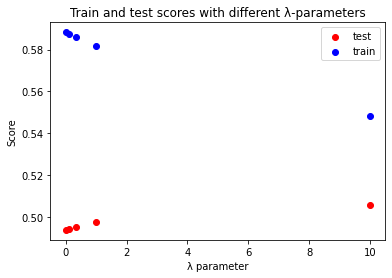

In [ ]:
plt.scatter(x1_test, y1_test, label='test', color='red')
plt.scatter(x1_train, y1_train, label='train', color='blue')
plt.title('Train and test scores with different λ-parameters')
plt.ylabel('Score')
plt.xlabel('λ parameter')
plt.legend(loc='best')
plt.show()

#### Sag

In [ ]:
sag = pd.read_csv('clean_sag_results_file.csv')
sag

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,228.592127,46.722717,2.291868,0.489337,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.503603,0.502107,0.505107,0.503606,0.001225,1.0,0.563306,0.563723,0.563255,0.563428,0.000209
1,2,208.670107,1.214861,1.280611,0.003612,1.0,l2,"{'C': 1.0, 'penalty': 'l2'}",0.483471,0.482989,0.484425,0.483628,0.000597,2.0,0.613948,0.613824,0.613385,0.613719,0.000241
2,4,213.306917,3.393099,1.318528,0.015357,3.0,l2,"{'C': 3.0, 'penalty': 'l2'}",0.476582,0.476699,0.477925,0.477069,0.000607,3.0,0.623230,0.622659,0.621706,0.622532,0.000629
3,6,209.091813,1.012354,1.269711,0.004515,10.0,l2,"{'C': 10, 'penalty': 'l2'}",0.474056,0.474026,0.475766,0.474616,0.000813,4.0,0.626835,0.625775,0.624912,0.625840,0.000786
4,1,216.252013,9.936686,1.296514,0.014646,NaN,none,"{'C': none, 'penalty': 'none'}",0.472945,0.472565,0.474369,0.473293,0.000776,5.0,0.628295,0.627083,0.626267,0.627215,0.000833


In [ ]:
y1_train = list(sag['mean_train_score'])
x1_train = [1 / i for i in list(sag['param_C'])]
x1_train[1] = 0
y1_test = list(sag['mean_test_score'])
x1_test = [1 / i for i in list(sag['param_C'])]
x1_test[1] = 0

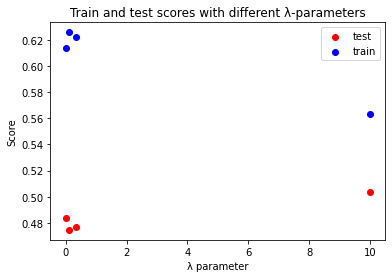

In [ ]:
plt.scatter(x1_test, y1_test, label='test', color='red')
plt.scatter(x1_train, y1_train, label='train', color='blue')
plt.title('Train and test scores with different λ-parameters')
plt.ylabel('Score')
plt.xlabel('λ parameter')
plt.legend(loc='best')
plt.show()

## Total training

Итоговое обучение модели

In [ ]:
max_itr = 500
solver = 'saga'
penalty = 'l2'
C = 0.1

In [ ]:
clf = LogisticRegression(solver = solver, max_iter = max_itr, penalty = penalty, C = C)

scores = cross_val_score(clf, X_train_all, y_train, cv=3, scoring= f_scorer)
print(f'Cross val scores: {scores}')
print(f'Mean cross val score: {scores.mean():.4f}')
print('-'*40)

clf.fit(X_train_all, y_train)
y_train_preds = clf.predict(X_train_all)
y_val_preds = clf.predict(X_val_all)

print('Train score')
print_metric(y_train, y_train_preds)
print('-'*40)

print('Val score')
print_metric(y_val, y_val_preds)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Cross val scores: [0.50344276 0.50240161 0.50648605]
Mean cross val score: 0.5041
----------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train score
0.4821   Custom f-score
0.4531   Contradiction's recall
0.5315   Accuracy
               precision    recall    fscore
contradiction   0.550384  0.453091  0.461245
neutral         0.518099  0.530634  0.529353
entailment      0.529966  0.610830  0.601650
Weighted*       0.545113  0.476619  0.482096
----------------------------------------
Val score
0.4769   Custom f-score
0.4565   Contradiction's recall
0.5126   Accuracy
               precision    recall    fscore
contradiction   0.515847  0.456532  0.461842
neutral         0.468099  0.553903  0.543932
entailment      0.560110  0.527514  0.530602
Weighted*       0.515498  0.473367  0.476927


## Результаты

Так как не удалось получить csv файлы тестовой выборки для graph2vec, было принято решение использовать старый классификатор (хотя модель с синтаксисом показывает более высокие результаты)

In [53]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

Получение и сохранение результатов на тестовой выборке

In [54]:
y_test_preds = clf.predict(X_test1) 
output = pd.DataFrame({'pairID': test_matched.pairID, 'predicted_label': y_test_preds}) 
output.to_csv('results_matched.csv', index=False)

In [55]:
y_test_preds = clf.predict(X_test2) 
output = pd.DataFrame({'pairID': test_mismatched.pairID, 'predicted_label': y_test_preds}) 
output.to_csv('results_mismatched.csv', index=False)